# Modelling - All Reps

For this notebook I took the data in the form we left it in after the EDA notebook. There we created a dataset where each row represented a single exercise and contained the euler data for all of the reps performed for that exercise. From there we will perform some modelling on the data to see how well we can predict these movements based off our data in the current form.

There will be a bit of experimentation on scaling methods (where applicable) and splitting methods. The models used for this notebook are RandomForest, Support Vector Machine (SVM) and XGBoost with GridSearchCV for hyperparameter tuning.

In [1]:
# Libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# importing prepared dataset

data = pd.read_csv('../data/csvs/exercise_df_pre_modelling.csv')

## A Little more EDA

### Encoding 

Before I can start plugging my data into some models there are a few more things I need to take care of. First we are going to encode the categorical columns.

In [3]:
# encoding categorical columns and saving mapping model 

columns_to_encode = ['exercise', 'watch_location', 'crown_orientation']

label_mappings = {}
enc = LabelEncoder()

for column in columns_to_encode:
    enc.fit_transform(data[column])
    
    data[f'{column}'] = enc.transform(data[column])
    label_mappings[column] = dict(zip(enc.classes_, enc.transform(enc.classes_)))

# Display the label mappings
for column, mapping in label_mappings.items():
    print(f"Column: {column}")
    for label, encoded_value in mapping.items():
        print(f"  {label} -> {encoded_value}")
    print()

Column: exercise
  ARM_RAISE-DUMBBELL -> 0
  BICEP_CURL-DUMBBELL -> 1
  BIRD_DOG -> 2
  BURPEE -> 3
  CRUNCHES -> 4
  HAMMER_CURL-DUMBBELL -> 5
  OVERHEAD_PRESS-DUMBBELL -> 6
  TRICEP_KICKBACK-BENT_OVER+SINGLE_ARM-DUMBBELL-LEFT -> 7
  TRICEP_KICKBACK-BENT_OVER+SINGLE_ARM-DUMBBELL-RIGHT -> 8
  V_UP -> 9

Column: watch_location
  LEFT -> 0
  RIGHT -> 1

Column: crown_orientation
  LEFT -> 0
  RIGHT -> 1



In [4]:
data.head(1)

,exercise,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,wrist_offset_deg,avg_rep_time,euler_x_1,euler_y_1,...,euler_z_117,euler_x_118,euler_y_118,euler_z_118,euler_x_119,euler_y_119,euler_z_119,euler_x_120,euler_y_120,euler_z_120
0,0,1,0,4.818261,0.851037,0.024017,9.201472,2.970833,-0.085816,-1.236302,...,0.068083,0.316288,-0.37655,0.04075,0.278083,-0.85458,0.019844,0.186179,-1.131981,0.086393


In [5]:
# Taking a quick look at our data types

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1766 entries, 0 to 1765
Columns: 368 entries, exercise to euler_z_120
dtypes: float64(365), int32(3)
memory usage: 4.9 MB


We can see now that all of our data are int or float.

In [6]:
data.iloc[:,:20].describe()

,exercise,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,wrist_offset_deg,avg_rep_time,euler_x_1,euler_y_1,euler_z_1,euler_x_2,euler_y_2,euler_z_2,euler_x_3,euler_y_3,euler_z_3,euler_x_4,euler_y_4,euler_z_4
count,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000
mean,4.166478,0.498301,0.500566,3.074503,1.138741,0.158980,-0.549057,2.846878,0.004419,-0.004107,-0.013944,0.004271,-0.005171,-0.003880,0.021113,-0.010632,0.019793,0.023692,-0.010747,0.031887
std,2.854851,0.500139,0.500141,1.811325,0.386085,0.120422,18.839038,2.365388,1.824808,0.772811,1.679326,1.788693,0.734431,1.701176,1.711599,0.671153,1.731498,1.599509,0.691781,1.737085
min,0.000000,0.000000,0.000000,0.000068,0.500301,0.000028,-44.753317,0.773077,-3.134623,-1.529143,-3.138694,-3.141491,-1.506369,-3.119051,-3.141076,-1.542554,-3.125885,-3.139041,-1.541828,-3.140974
25%,2.000000,0.000000,0.000000,1.515603,0.846718,0.060764,-14.708370,1.523295,-1.438699,-0.609314,-1.597995,-1.342800,-0.578224,-1.625086,-1.320959,-0.514983,-1.574014,-1.250441,-0.520545,-1.593765
50%,4.000000,0.000000,1.000000,3.047515,1.103593,0.134453,-0.955696,2.094949,0.021462,-0.033025,0.023405,-0.027682,-0.029389,0.051814,0.039280,-0.020756,0.039621,0.008227,-0.016577,0.036437
75%,6.000000,1.000000,1.000000,4.609374,1.389512,0.226374,13.579004,3.087500,1.412547,0.629659,1.540238,1.332360,0.592619,1.510232,1.322435,0.496829,1.524568,1.254920,0.504528,1.597221
max,9.000000,1.000000,1.000000,6.278917,2.861832,0.777604,44.344465,16.791667,3.139900,1.521754,3.140739,3.140135,1.536095,3.137109,3.139074,1.497512,3.139442,3.138381,1.533896,3.141549


While scaling is necessary for many models, it is not necessary for all. I will be trying a RandomForest model first which does not require scaling, however it is recommended for some of the other models and does not affect the RandomForest model so I will have a scaled available for use.

### Scaling

In [7]:
# Scaling data using Robust Scaler

columns_to_scale = data.columns[3:]
scaler = RobustScaler()

scaled_data = scaler.fit_transform(data[columns_to_scale])
scaled_df = pd.concat([data.iloc[:, :3], pd.DataFrame(scaled_data, columns=columns_to_scale)], axis=1)

In [8]:
# Format setting for how the floats display

pd.set_option('display.float_format', '{:.6f}'.format)

In [9]:
scaled_df.iloc[:,:10].describe()

,exercise,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,wrist_offset_deg,avg_rep_time,euler_x_1,euler_y_1
count,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000
mean,4.166478,0.498301,0.500566,0.008723,0.064754,0.148101,0.014375,0.480710,-0.005977,0.023340
std,2.854851,0.500139,0.500141,0.585475,0.711292,0.727143,0.665987,1.512199,0.640004,0.623752
min,0.000000,0.000000,0.000000,-0.985027,-1.111457,-0.811695,-1.548310,-0.845077,-1.106914,-1.207547
25%,2.000000,0.000000,0.000000,-0.495160,-0.473246,-0.444954,-0.486177,-0.365460,-0.512113,-0.465135
50%,4.000000,0.000000,1.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.000000,1.000000,1.000000,0.504840,0.526754,0.555046,0.513823,0.634540,0.487887,0.534865
max,9.000000,1.000000,1.000000,1.044486,3.239239,3.883531,1.601427,9.395649,1.093711,1.254893


In [118]:
# Saving dataframe before removing columns

scaled_df.to_csv('../data/csvs/scaled_df_rep_per_line.csv', index=False)

### Splitting

On my first run through my work I had initially split the data using a stratified method to ensure I got an even distribution of the exercises. However, my curiosity getting the better of me requires that I also try a set split by percentage. This does make the numerous modelling attempts below a little confusing to follow, but I have tried to label things appropriately to make it more clear.

#### *Scaled*

In [10]:
# Splitting scaled data into X and y

X_scale=scaled_df.drop(['exercise'], axis=1)
y_scale=scaled_df['exercise']

In [11]:
print(X_scale.shape, y_scale.shape)

(1766, 367) (1766,)


#### **Stratified**

In [14]:
# Stratified split on Scaled

stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in stratified_splitter.split(X_scale, y_scale):
    X_train_strat_s, X_test_strat_s = X_scale.iloc[train_index], X_scale.iloc[test_index]
    y_train_strat_s, y_test_strat_s = y_scale.iloc[train_index], y_scale.iloc[test_index]

In [15]:
# Looking at the breakdown by exercise for the training and testing sets

print(y_train_strat_s.value_counts())
print(y_test_strat_s.value_counts())

print(y_train_strat_s.value_counts().sum())
print(y_test_strat_s.value_counts().sum())

exercise
2    160
1    160
3    160
9    160
5    160
0    158
6    157
4    139
8     80
7     78
Name: count, dtype: int64
exercise
0    40
2    40
1    40
5    40
9    40
3    40
6    39
4    35
7    20
8    20
Name: count, dtype: int64
1412
354


#### **Unstratified**

In [17]:
# Unstratified split using train_test_split on scaled data

X_train_un_s, X_test_un_s, y_train_un_s, y_test_un_s = train_test_split(X_scale, y_scale, test_size = 0.3, random_state = 3)

In [18]:
# Looking at the breakdown by exercise for the training and testing sets

print(y_train_un_s.value_counts())
print(y_test_un_s.value_counts())

print(y_train_un_s.value_counts().sum())
print(y_test_un_s.value_counts().sum())

exercise
2    150
3    148
9    147
6    137
0    135
1    133
5    128
4    120
8     70
7     68
Name: count, dtype: int64
exercise
5    72
1    67
0    63
6    59
4    54
9    53
3    52
2    50
7    30
8    30
Name: count, dtype: int64
1236
530


Below is a plot to visualize the breakdown of the target data with the different splitting methods. 

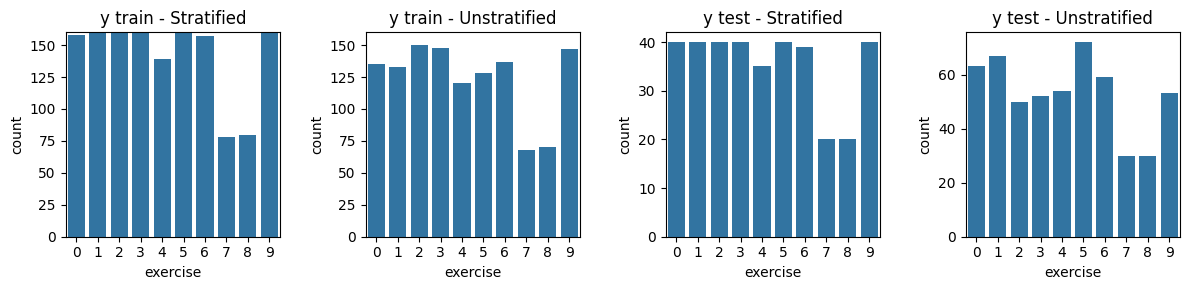

In [20]:
# Visualizing the differences in splitting methods

max_count_test = max(y_train_strat_s.value_counts().max(), y_test_un_s.value_counts().max())

plt.figure(figsize=(12, 3))

plt.subplot(1, 4, 1)
sns.countplot(x=y_train_strat_s)
plt.ylim(0, max_count_test)  
plt.title('y train - Stratified')

plt.subplot(1, 4, 2)
sns.countplot(x=y_train_un_s)
plt.ylim(0, max_count_test) 
plt.title('y train - Unstratified')

plt.subplot(1, 4, 3)
sns.countplot(x=y_test_strat_s)
plt.title('y test - Stratified')

plt.subplot(1, 4, 4)
sns.countplot(x=y_test_un_s)
plt.title('y test - Unstratified')

plt.tight_layout()
plt.subplots_adjust(wspace=0.4)  
plt.show()


## Modelling

### **RandomForest**

In [23]:
# setting up basic model

rfc = RandomForestClassifier(random_state = 3)

#### *Stratified*

In [24]:
# fitting the model to the stratified/scaled data

rfc.fit(X_train_strat_s, y_train_strat_s)

RandomForestClassifier(random_state=3)

In [25]:
# running the predictions on training and testing data

y_train_pred_strat_s = rfc.predict(X_train_strat_s)
y_test_pred_strat_s = rfc.predict(X_test_strat_s)

In [26]:
# accuracy results for basic RandomForestClassifier

print('Training accuracy (Scaled/Stratified) :',accuracy_score(y_train_strat_s, y_train_pred_strat_s))
print('Testing accuracy  (Scaled/Stratified) :' ,accuracy_score(y_test_strat_s, y_test_pred_strat_s))

Training accuracy (Scaled/Stratified) : 1.0
Testing accuracy  (Scaled/Stratified) : 0.8954802259887006


In [27]:
# Classification Report

print(classification_report(y_test_strat_s, y_test_pred_strat_s))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        40
           1       0.84      0.93      0.88        40
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        40
           4       0.87      0.77      0.82        35
           5       0.79      0.85      0.82        40
           6       0.73      0.90      0.80        39
           7       0.94      0.75      0.83        20
           8       0.87      0.65      0.74        20
           9       0.98      1.00      0.99        40

    accuracy                           0.90       354
   macro avg       0.90      0.87      0.88       354
weighted avg       0.90      0.90      0.90       354



In [28]:
# Confusion Matrix

conf_matrix = confusion_matrix(y_test_strat_s, y_test_pred_strat_s)
conf_matrix

array([[36,  0,  0,  0,  0,  4,  0,  0,  0,  0],
       [ 0, 37,  0,  0,  3,  0,  0,  0,  0,  0],
       [ 0,  0, 40,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 40,  0,  0,  0,  0,  0,  0],
       [ 0,  7,  0,  0, 27,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0, 34,  5,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  4, 35,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  1,  2, 15,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  6,  1, 13,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 40]], dtype=int64)

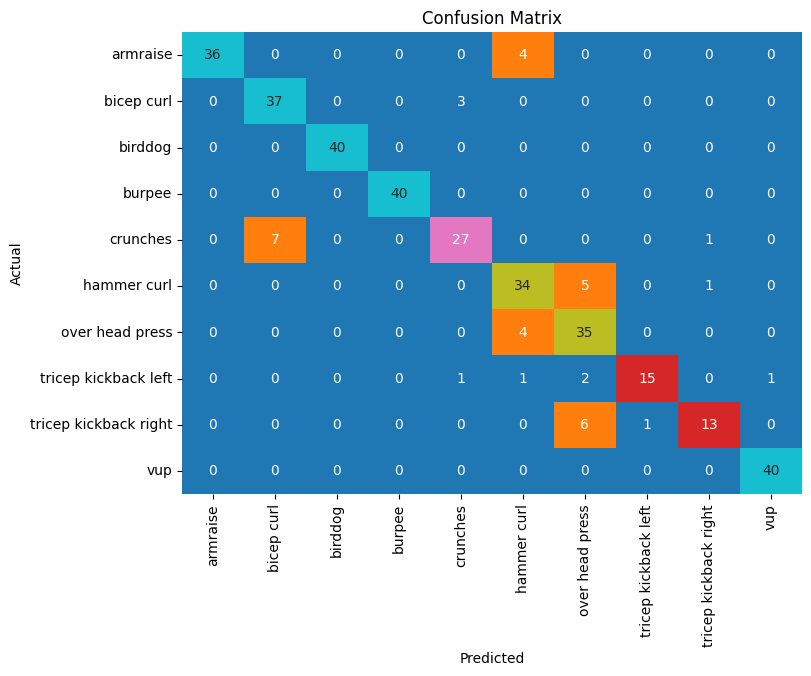

In [29]:
# Plotting the confusion matrix as a heatmap

plt.figure(figsize=(8, 6))
class_labels = ['armraise', 'bicep curl', 'birddog', 'burpee', 'crunches', 'hammer curl', 'over head press', 'tricep kickback left', 'tricep kickback right', 'vup']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='tab10', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Misclassification per exercise:

0) armraise - 4 > these 4 were predicted to be hammer curls
1) bicep curl - 3> these 3 were predicted to be crunches
2) birddog - 0
3) burpee - 0
4) crunches - 8 > 7 were predicted to be bicep curls
5) hammer curl - 6 > 5/6 were predicted to be over head presses
6) over head press - 4
7) tricep kickback left - 5
8) tricep kickback right - 7 > 6/7 were predicted to be over head presses
9) vup - 0

#### *Unstratified*

In [30]:
# fitting model to unstratified dataset

rfc.fit(X_train_un_s, y_train_un_s)

RandomForestClassifier(random_state=3)

In [31]:
# running the predictions on training and testing data

y_train_pred_un_s = rfc.predict(X_train_un_s)
y_test_pred_un_s = rfc.predict(X_test_un_s)

In [32]:
# Accuracy results for this model

print('Train accuracy:',accuracy_score(y_train_un_s, y_train_pred_un_s))
print('Test accuracy:',accuracy_score(y_test_un_s, y_test_pred_un_s))

Train accuracy: 1.0
Test accuracy: 0.8962264150943396


In [33]:
# Classification Report

print(classification_report(y_test_un_s, y_test_pred_un_s))


              precision    recall  f1-score   support

           0       0.97      0.95      0.96        63
           1       0.89      0.96      0.92        67
           2       0.98      1.00      0.99        50
           3       1.00      1.00      1.00        52
           4       0.88      0.85      0.87        54
           5       0.82      0.76      0.79        72
           6       0.73      0.92      0.81        59
           7       0.86      0.63      0.73        30
           8       0.96      0.73      0.83        30
           9       0.96      1.00      0.98        53

    accuracy                           0.90       530
   macro avg       0.91      0.88      0.89       530
weighted avg       0.90      0.90      0.89       530



In [34]:
# Confusion Matrix

conf_matrix = confusion_matrix(y_test_un_s, y_test_pred_un_s)
conf_matrix

array([[60,  0,  0,  0,  0,  3,  0,  0,  0,  0],
       [ 0, 64,  0,  0,  3,  0,  0,  0,  0,  0],
       [ 0,  0, 50,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 52,  0,  0,  0,  0,  0,  0],
       [ 0,  8,  0,  0, 46,  0,  0,  0,  0,  0],
       [ 2,  0,  1,  0,  0, 55, 13,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  5, 54,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  4,  3, 19,  1,  1],
       [ 0,  0,  0,  0,  1,  0,  4,  2, 22,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 53]], dtype=int64)

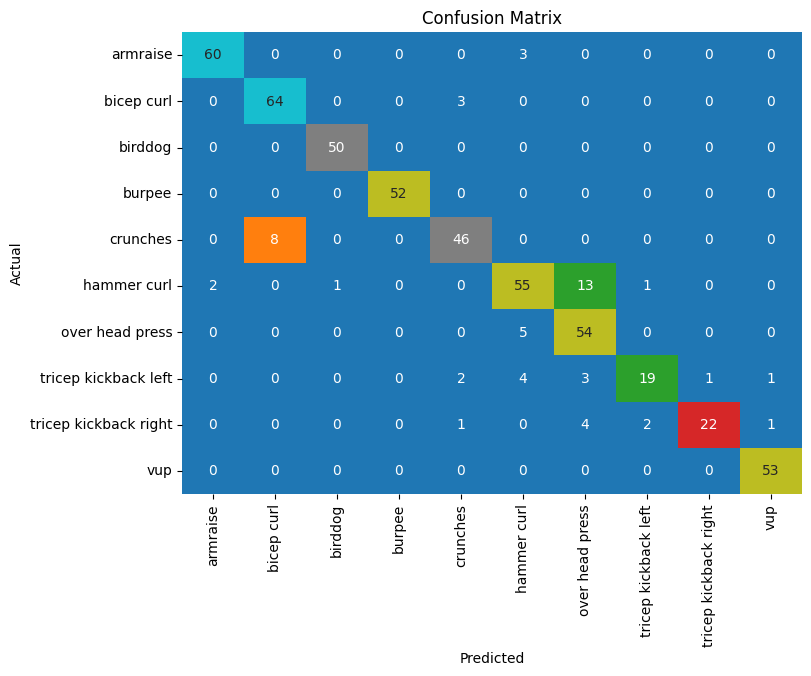

In [84]:
# Plotting the confusion matrix as a heatmap

plt.figure(figsize=(8, 6))
class_labels = ['armraise', 'bicep curl', 'birddog', 'burpee', 'crunches', 'hammer curl', 'over head press', 'tricep kickback left', 'tricep kickback right', 'vup']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='tab10', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Misclassification per exercise: The first number is from the confusion matrix with the stratified data. While the accuracy score is extremely close, the stratified results look better on the confusion matrix. The numbers below are the total amount of exercises that were miscalculated for each exercise.

0) armraise - 4 - 3
1) bicep curl - 3 - 3
2) birddog - 0 - 0
3) burpee - 0 - 0
4) crunches - 8 - 8
5) hammer curl - 6 - 17
6) over head press - 4 - 5
7) tricep kickback left - 5 - 11
8) tricep kickback right - 7 - 8
9) vup - 0 - 0

It is interesting to see which exercises are being confused with others. With the RandomForest model, one of the biggest confusions seemed to be between crunches and bicep curls. As we saw before in the EDA notebook, there is a lot of variation with regards to how the exercises plot, even when comparing to other versions of the same exercise. So while there are definitely some exercise sets that are extremely different from each other, when you look at these plots, it is easy to see why there also might be some confusion.

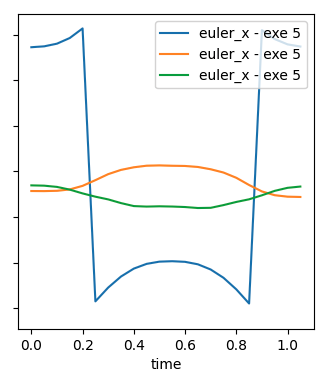   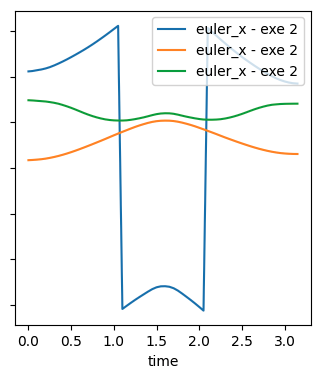 \
The first image shows one crunch and the second one bicep curl with dumbbell.

Over all the models achieved almost 90%! That's not too bad for a first run through. Now we can try some hyperparameter tuning to see if we can make it better. \
I will be using GridSearchCV to assess optimal parameters for my models. Because the stratified split looked a bit better for the base model I will be using that for my hyperparameter tuning.

### Hyperparameter Tuning for RandomForest

In [21]:
# Parameter settings

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

This model took some time to run. Just something to keep in mind before executing it.

In [24]:
# Using GridSearchCV

grid_search_rfc = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1)
grid_search_rfc.fit(X_train_strat_s, y_train_strat_s)

print("Best Hyperparameters:", grid_search_rfc.best_params_)

best_model_rfc = grid_search_rfc.best_estimator_


Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [25]:
y_train_best_model_strat_s = best_model_rfc.predict(X_train_strat_s)
y_pred_best_model_strat_s = best_model_rfc.predict(X_test_strat_s)

In [26]:
print('Train Accuracy score :', accuracy_score(y_train_strat_s, y_train_best_model_strat_s))
print('Test Accuracy score :', accuracy_score(y_test_strat_s, y_pred_best_model_strat_s))


Train Accuracy score : 1.0
Test Accuracy score : 0.9067796610169492


In [27]:
# Confusion Matrix

conf_matrix = confusion_matrix(y_test_strat_s, y_pred_best_model_strat_s)
conf_matrix

array([[36,  0,  0,  0,  0,  4,  0,  0,  0,  0],
       [ 0, 37,  0,  0,  3,  0,  0,  0,  0,  0],
       [ 0,  0, 40,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 40,  0,  0,  0,  0,  0,  0],
       [ 0,  7,  0,  0, 27,  0,  0,  0,  1,  0],
       [ 1,  0,  0,  0,  0, 35,  3,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  3, 36,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  1,  2, 15,  0,  1],
       [ 0,  0,  0,  0,  0,  1,  2,  1, 16,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0, 39]], dtype=int64)

Seems like the hyperparameter tuning made the model a little bit better. Lets give some other models a try.

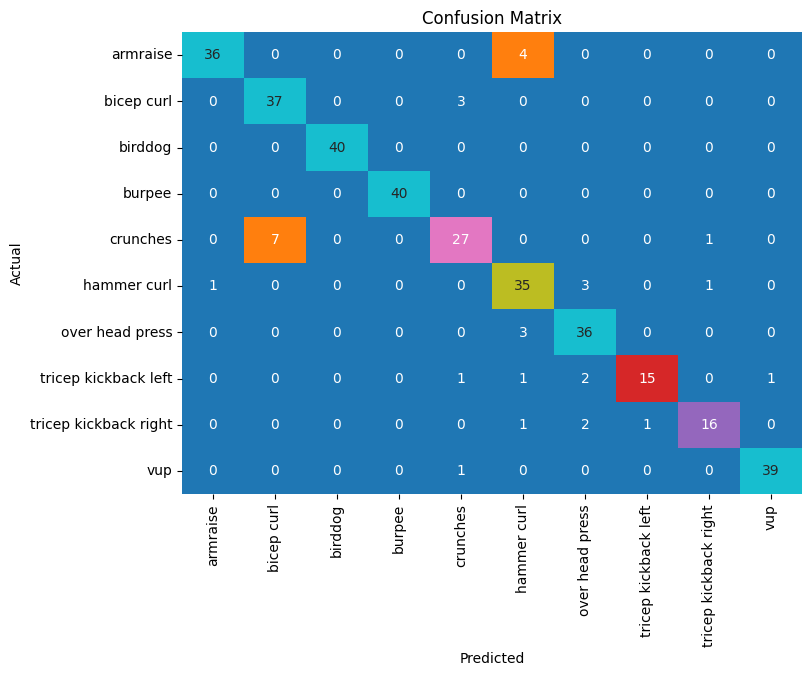

In [28]:
# Plotting the confusion matrix as a heatmap

plt.figure(figsize=(8, 6))
class_labels = ['armraise', 'bicep curl', 'birddog', 'burpee', 'crunches', 'hammer curl', 'over head press', 'tricep kickback left', 'tricep kickback right', 'vup']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='tab10', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Support Vector Machine (SVM)

#### *Stratified*

In [30]:
# Trying a quick SVM run through with stratified/scaled data

svm_model = SVC(kernel='rbf', C=1)
svm_model.fit(X_train_strat_s, y_train_strat_s)

y_pred_svm_train_strat_s = svm_model.predict(X_train_strat_s)
print('Training accuracy:', accuracy_score(y_train_strat_s, y_pred_svm_train_strat_s))

y_pred_svm_test_strat_s = svm_model.predict(X_test_strat_s)
print('Test accuracy:', accuracy_score(y_test_strat_s, y_pred_svm_test_strat_s))

Training accuracy: 0.9121813031161473
Test accuracy: 0.7994350282485876


In [32]:
# Classification Report

print(classification_report(y_test_strat_s, y_pred_svm_test_strat_s))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90        40
           1       0.82      0.82      0.82        40
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        40
           4       0.78      0.71      0.75        35
           5       0.59      0.57      0.58        40
           6       0.47      0.72      0.57        39
           7       0.79      0.55      0.65        20
           8       0.69      0.45      0.55        20
           9       1.00      0.97      0.99        40

    accuracy                           0.80       354
   macro avg       0.81      0.77      0.78       354
weighted avg       0.82      0.80      0.80       354



The SVM model clearly did not do as good as the RandomForest model off the bat, but of course we will try some hyperparameter tuning with GridSearchCV to see if we can make it better.

#### *Unstratified*

In [33]:
# Trying a quick SVM run through with unstratified/scaled data

svm_model = SVC(kernel='rbf', C=1)
svm_model.fit(X_train_un_s, y_train_un_s)

y_pred_svm_train_un_s = svm_model.predict(X_train_un_s)
print('Training accuracy:', accuracy_score(y_train_un_s, y_pred_svm_train_un_s))

y_pred_svm_test_un_s = svm_model.predict(X_test_un_s)
print('Test accuracy:', accuracy_score(y_test_un_s, y_pred_svm_test_un_s))

Training accuracy: 0.8996763754045307
Test accuracy: 0.809433962264151


Surprisingly the unstratified scaled data did a little bit better for this model.

### SVM Hypertuning with GridSearchCV

In [36]:
# using stratified/scaled data, setting up parameter grid and fitting to data

param_grid = {'C':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'degree': [2, 3, 4, 5],
              'kernel': ['rbf', 'poly']}

grid_svc = GridSearchCV(SVC(), param_grid, cv=5)
grid_svc.fit(X_train_strat_s, y_train_strat_s)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50,
                               100, 500, 1000],
                         'degree': [2, 3, 4, 5],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']})

In [38]:
# Viewing the best model parameters

grid_svc.best_params_

{'C': 10, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}

In [39]:
# Running the model with the best parameters

best_params = {'C': 100, 'gamma': 0.001,'degree': 2, 'kernel': 'rbf'}
best_svc_model = SVC(**best_params)

best_svc_model.fit(X_train_strat_s, y_train_strat_s)
y_train_svm_best = best_svc_model.predict(X_train_strat_s)
y_pred_svm_best = best_svc_model.predict(X_test_strat_s)

In [40]:
# Accuracy scores

accuracy_train = accuracy_score(y_train_strat_s, y_train_svm_best)
print(f"Train Accuracy: {accuracy_train}")
accuracy_test = accuracy_score(y_test_strat_s, y_pred_svm_best)
print(f"Test Accuracy: {accuracy_test}")


Train Accuracy: 0.9872521246458924
Test Accuracy: 0.8785310734463276


In [40]:
#Classification Report

classification_rep = classification_report(y_test_strat_s, y_pred_svm_best)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.92      0.90      0.91        40
           1       0.88      0.88      0.88        40
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        40
           4       0.81      0.74      0.78        35
           5       0.73      0.68      0.70        40
           6       0.78      0.79      0.78        39
           7       0.87      1.00      0.93        20
           8       0.73      0.95      0.83        20
           9       1.00      0.93      0.96        40

    accuracy                           0.88       354
   macro avg       0.87      0.89      0.88       354
weighted avg       0.88      0.88      0.88       354



The hyperparameter tuning improved the SVM model, but none of the SVM variations did as well as the RandomForest. Going to try one more for funsies!

## XGBoost

In [41]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")
warnings.filterwarnings("ignore", category=UserWarning, message="`eval_metric` in `fit` method is deprecated*")
warnings.filterwarnings("ignore", category=UserWarning, message="`early_stopping_rounds` in `fit` method is deprecated*")

For this model I do not see any point in playing around with the multiple data sets. So we will create this model on the Startified/Scaled data.

#### *Stratified*

In [42]:
# parameter set up
params = {
    'objective': 'multi:softmax',
    'num_class': len(y_train_strat_s.unique()),
    'max_depth': 6,
    'eta': 0.3,
    'subsample':1,
    'colsample_bytree':1
}

n_rounds = 100

In [43]:
# Convert to DMatrix

d_train_strat_s = xgb.DMatrix(X_train_strat_s, label=y_train_strat_s)
d_test_strat_s = xgb.DMatrix(X_test_strat_s, label=y_test_strat_s)

In [44]:
# Setting up the XGBoost model

model_xgb = xgb.train(params, d_train_strat_s, n_rounds)

In [45]:
y_train_pred_xgb_strat_s = model_xgb.predict(d_train_strat_s)
y_pred_xgb_strat_s = model_xgb.predict(d_test_strat_s)

In [46]:
# Checking accuracy score.

train_acc = accuracy_score(y_train_strat_s, y_train_pred_xgb_strat_s)
print(f"Train Accuracy: {train_acc}")
test_acc = accuracy_score(y_test_strat_s, y_pred_xgb_strat_s)
print(f"Train Accuracy: {test_acc}")

Train Accuracy: 1.0
Train Accuracy: 0.9661016949152542


This is our best accuracy score so far! Not too bad! The speed of running this model compared to the others is so much faster thanks to the DMatrix format that the XGBoost uses. That would definitely make it more useful for more real-times situations.

In [47]:
# Classification Report

print(classification_report(y_test_strat_s, y_pred_xgb_strat_s))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        40
           1       0.97      0.95      0.96        40
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        40
           4       0.94      0.97      0.96        35
           5       0.85      0.97      0.91        40
           6       0.97      0.90      0.93        39
           7       1.00      0.95      0.97        20
           8       0.95      0.95      0.95        20
           9       1.00      1.00      1.00        40

    accuracy                           0.97       354
   macro avg       0.97      0.96      0.97       354
weighted avg       0.97      0.97      0.97       354



In [48]:
# Confusion Matrix

conf_matrix_xgb = confusion_matrix(y_test_strat_s, y_pred_xgb_strat_s)
conf_matrix_xgb

array([[38,  0,  0,  0,  0,  2,  0,  0,  0,  0],
       [ 0, 38,  0,  0,  2,  0,  0,  0,  0,  0],
       [ 0,  0, 40,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 40,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 34,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 39,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  4, 35,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 19,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0, 19,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 40]], dtype=int64)

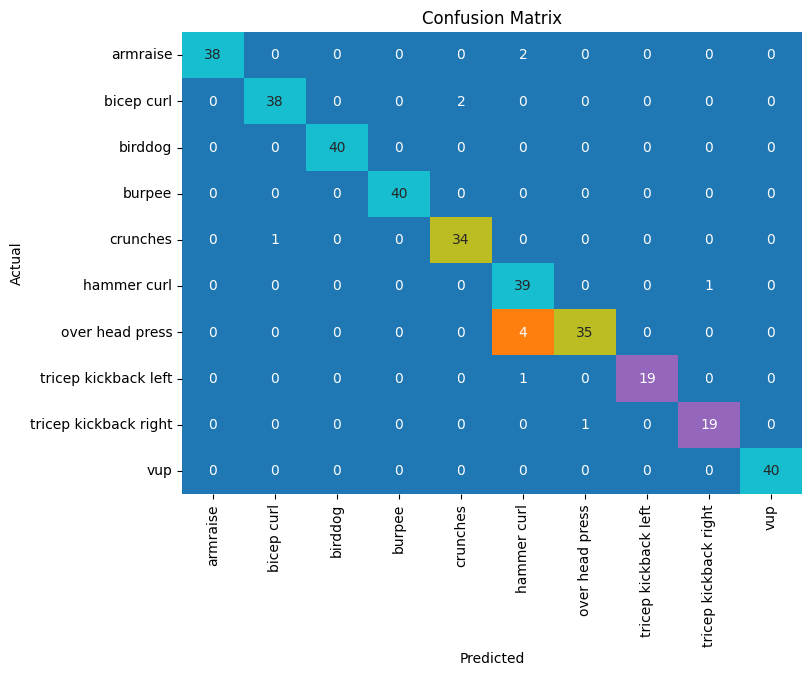

In [49]:
# Plotting the confusion matrix as a heatmap

plt.figure(figsize=(8, 6))
class_labels = ['armraise', 'bicep curl', 'birddog', 'burpee', 'crunches', 'hammer curl', 'over head press', 'tricep kickback left', 'tricep kickback right', 'vup']
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='tab10', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Hyperparameter Tuning with GridSearchCV

In order to use Gridsearch with XGBoost we need to switch over to the sklearn format of XGBoost which is XGBClassifier.

In [50]:
# Define the hyperparameter grid

param_grid = {
    'objective': ['multi:softmax'],
    'max_depth': [3, 4, 5, 6, 7],
    'eta': [0.2, 0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1],
}

# Train the initial XGBoost model
model_xgbc = XGBClassifier()
grid_search_xgb = GridSearchCV(model_xgbc, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search_xgb.fit(X_train_strat_s, y_train_strat_s)

print("Best set of hyperparameters: ", grid_search_xgb.best_params_)

Best set of hyperparameters:  {'eta': 0.2, 'max_depth': 4, 'objective': 'multi:softmax', 'subsample': 1}


In [51]:
# Setting up model with tuned parameters

best_params = grid_search_xgb.best_params_
best_xgb_model = xgb.XGBClassifier(**best_params)

best_xgb_model.fit(X_train_strat_s, y_train_strat_s)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [52]:
# prediction
y_train_pred = best_xgb_model.predict(X_train_strat_s)
y_pred = best_xgb_model.predict(X_test_strat_s)

In [53]:
# obtaining accuracy score
accuracy_train = accuracy_score(y_train_strat_s, y_train_pred)
print("Train Accuracy: ", accuracy_train)
accuracy_test = accuracy_score(y_test_strat_s, y_pred)
print("Test Accuracy: ", accuracy_test)

Train Accuracy:  1.0
Test Accuracy:  0.96045197740113


In [54]:
# Classification Report

print("\nClassification Report:\n", classification_report(y_test_strat_s, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        40
           1       0.97      0.97      0.97        40
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        40
           4       0.97      0.94      0.96        35
           5       0.81      0.97      0.89        40
           6       0.97      0.85      0.90        39
           7       1.00      0.95      0.97        20
           8       0.90      0.95      0.93        20
           9       1.00      1.00      1.00        40

    accuracy                           0.96       354
   macro avg       0.96      0.96      0.96       354
weighted avg       0.96      0.96      0.96       354



In [55]:
# Confusion Matrix

conf_matrix_xgb_best = confusion_matrix(y_test_strat_s, y_pred)

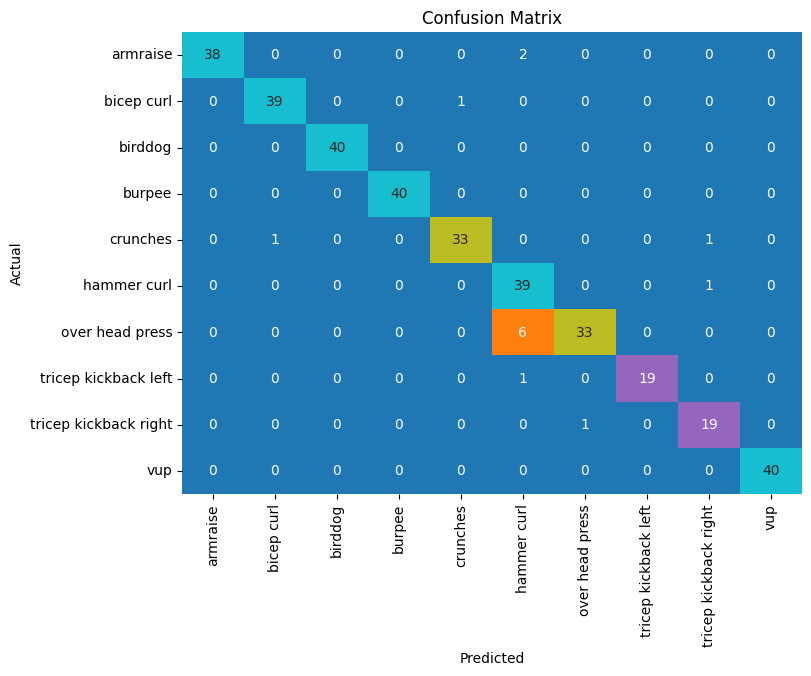

In [56]:
# Plotting the confusion matrix as a heatmap

plt.figure(figsize=(8, 6))
class_labels = ['armraise', 'bicep curl', 'birddog', 'burpee', 'crunches', 'hammer curl', 'over head press', 'tricep kickback left', 'tricep kickback right', 'vup']
sns.heatmap(conf_matrix_xgb_best, annot=True, fmt='d', cmap='tab10', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

There is a very slight decrease in accuracy after the tuning, but both attempts with the XGBoost model give more accurate predictions than any of the other models tried. 96% accuracy being the highest with the XGBoost and also computationally the fastest.

There are some other ideas that I would be interested in trying on top the work that I have already done. 
I would be interested to see how the models do with the numbers from the rotation matrices as opposed to the euler values, without any feature engineering,
Can the models predict the movements without the parameter data from the json files?
How many reps need to be included for the models to achieve a decent accuracy result?

I will start a new notebook to try to explore some of these ideas.

Next notebook: modelling_no_parameters